In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [22]:
IMAGE_SIZE = 256
BATCH_SIZE = 25
CHANNELS = 3
EPOCHS = 50

In [23]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("Grape_types", shuffle=True, image_size=(IMAGE_SIZE,IMAGE_SIZE), batch_size=BATCH_SIZE)

Found 500 files belonging to 5 classes.


In [24]:
class_names = dataset.class_names
class_names

['Ak', 'Ala_Idris', 'Buzgulu', 'Dimnit', 'Nazli']

In [25]:
len(dataset)

20

In [26]:
for image_batch in dataset.take(1):
    print(image_batch[0].shape)

(25, 256, 256, 3)


In [27]:
#Take 80% of the data for training
training_ds = dataset.take(int(0.8*len(dataset)))
len(training_ds)

16

In [28]:
def get_dataset_partition(dataset, train_split=0.8, validation=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    dataset_size = len(dataset)

    if shuffle:
        dataset= dataset.shuffle(shuffle_size, seed=12)
    
    train_size = int(dataset_size * train_split)
    test_size = int(dataset_size * test_split)
    val_size = int(dataset_size * validation)

    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [29]:
train_ds, val_ds, test_ds = get_dataset_partition(dataset)

In [30]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

16
2
2


In [31]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [32]:
resize_and_rescale = tf.keras.Sequential()
resize_and_rescale.add(keras.layers.Resizing(IMAGE_SIZE,IMAGE_SIZE))
resize_and_rescale.add(keras.layers.Rescaling(1.0/255))

In [33]:
data_augmentation = tf.keras.Sequential()
data_augmentation.add(keras.layers.RandomFlip("horizontal_and_vertical"))
data_augmentation.add(keras.layers.RandomRotation(0.2))

In [41]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = keras.Sequential()
model.add(resize_and_rescale)
model.add(data_augmentation)
#model.add(keras.layers.Input(shape=input_shape))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(2,2))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(2,2))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(2,2))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(2,2))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(2,2))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(2,2))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(len(class_names), activation="softmax"))

model.build(input_shape=input_shape)

In [42]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (25, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (25, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (25, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (25, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (25, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (25, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (25, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (25, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (25, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (25, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (25, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (25, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (25, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (25, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (25, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (25, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (25, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (25, 5)                     │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,877 (718.27 KB)

 Trainable params: 183,877 (718.27 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [46]:
history = model.fit(train_ds, epochs=100, batch_size=BATCH_SIZE, verbose=1, validation_data=val_ds)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.7625 - loss: 0.6263 - val_accuracy: 0.8600 - val_loss: 0.4847
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.7736 - loss: 0.6232 - val_accuracy: 0.8200 - val_loss: 0.4573
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.7209 - loss: 0.7179 - val_accuracy: 0.8000 - val_loss: 0.4720
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.6625 - loss: 0.8052 - val_accuracy: 0.8800 - val_loss: 0.4469
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.7950 - loss: 0.6069 - val_accuracy: 0.9000 - val_loss: 0.3511
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.8051 - loss: 0.5932 - val_accuracy: 0.9600 - val_loss: 0.2901
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.7622 - loss: 0.6111 - val_accuracy: 0.9000 - val_loss: 0.3694
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.8170 - loss: 0.4985 - val_accu

In [47]:
model.evaluate(test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9333 - loss: 0.0909


[0.08114936947822571, 0.9399999976158142]

In [48]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 16}

In [62]:
def predict(model, ddc):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


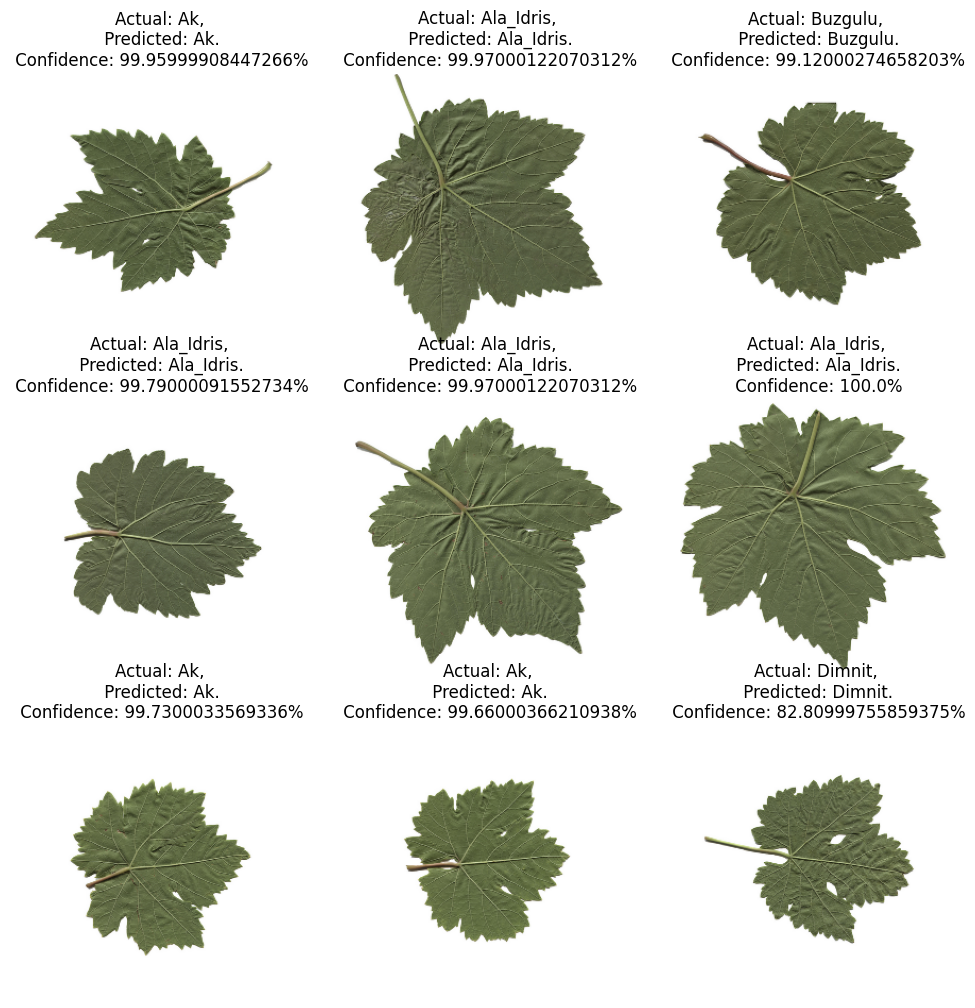

In [66]:
import numpy as np
plt.figure(figsize=(12, 12))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")